# Objectives

We are using the UCI Heart Disease Data after wrangling in the file data/heart.csv

We will try to predict the indication of heart disease in the target variable.

It has 14 columns, 13 potential feature variables and 1 boolean target variable, which is the diagnosis of coronary artery disease based on angiography, so we are doing a classification problem. 

In this notebook we will do exploratory data analysis to characterize the data and select candidate features to explain the target.

# 1. Load the data from data/heart.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import math

from library.sb_utils import save_file

In [4]:
heart_data = pd.read_csv("../data/heart.csv")
heart_data.info()
heart_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Age         303 non-null    int64
 1   Sex         303 non-null    int64
 2   ChestPain   303 non-null    int64
 3   SystolicBP  303 non-null    int64
 4   Chol        303 non-null    int64
 5   Glucose     303 non-null    int64
 6   RestECG     303 non-null    int64
 7   STMaxRate   303 non-null    int64
 8   STPain      303 non-null    int64
 9   STWave      303 non-null    int64
 10  STSlope     303 non-null    int64
 11  NumColor    303 non-null    int64
 12  Defects     303 non-null    int64
 13  AngioTgt    303 non-null    int64
dtypes: int64(14)
memory usage: 33.3 KB


,Age,Sex,ChestPain,SystolicBP,Chol,Glucose,RestECG,STMaxRate,STPain,STWave,STSlope,NumColor,Defects,AngioTgt
0,63,1,3,145,233,1,0,150,0,2,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1,2,0,2,1
3,56,1,1,120,236,0,1,178,0,1,2,0,2,1
4,57,0,4,120,354,0,1,163,1,1,2,0,2,1


### Data availability and types

All 14 columns have data in all 303 rows.  No missing data.
All columns are integers, now that I converted STWave's values and type in the Data Wrangling phase.


# 2. Correlations of the variables

Now let's look at the Pearson correlations of the candidate features to the target.

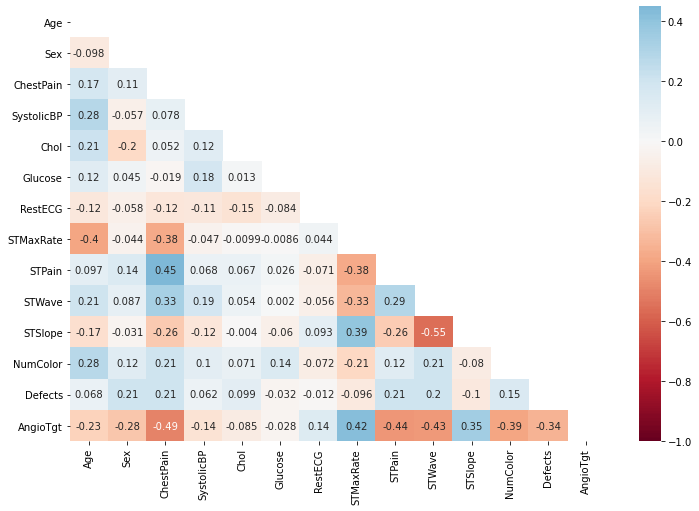

In [7]:
#Show a seaborn heatmap of correlations
plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(heart_data.corr()))
sns.heatmap(heart_data.corr(), mask=mask, vmin=-1, cmap='RdBu', center=0.0, annot=True); 

No strongly positive correlations to the target and only a few moderate positives of any sort: STMaxRate to AngioTgt +0.42, STSlope to AngioTgt +0.35, STPain to ChestPain at +0.45, STSlope to STMaxRate +0.39, and STWave to ChestPain +0.33.

Quite a few moderately negative correlations (light red): ChestPain to AngioTgt -0.49 (As we found in Data Wrangling, Chest Pain goes from worst at 1 to no pain at 4.)  STPain to AngioTgt -0.44, STWave to AngioTgt -0.43, NumColor to AngioTgt -0.39, Defects to AngioTgt -0.34, STSlope to STWave -0.55, STPain to STMaxRate -0.38, STMaxRate to ChestPain -0.38, and STWave to STMaxRate -0.33.

Let's examine these like we did the anomalous categoricals in the Data Wrangling phase.

In [58]:
def trendOverCategory(feature, base='AngioTgt', continuous_feat=False, max_value=1):
    sns.histplot(heart_data, x=feature, stat='probability')
    if (max_value==1):
        max_value = heart_data[base].max()
    if continuous_feat:
        pctgs = [(i, round(heart_data[round(heart_data[feature],-1) == i][base].mean()/max_value,3)) for i in np.sort(round(heart_data[feature],-1))]
    else:
        pctgs = [(i, round(heart_data[heart_data[feature] == i][base].mean(),3)) for i in np.sort(heart_data[feature].unique())]
        print(pctgs)
    lst1, lst2 = zip(*pctgs)
    if max_value == 1:
        plt.ylabel('% with {} value \n and % of those with {}'.format(feature, base))
    else:
        plt.ylabel('% with {} value \n and mean value of {}'.format(feature, base))
    plt.xlabel('{} indicator'.format(feature))
    plt.plot(lst1, lst2, color='orange', marker='.')
    

## Positive Correlations

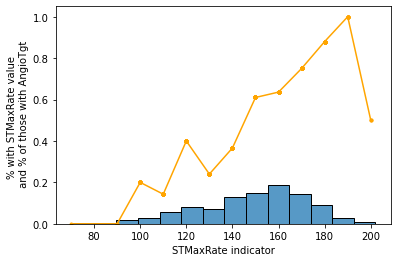

In [59]:
trendOverCategory('STMaxRate', continuous_feat=True)

STMaxRate looks like a pretty good indicator of heart disease.  But it's choppy on the left and at the last value of 200 bps, there were 2 subjects and 1 of them didn't have heart disease. The correlation coefficient is kept down to 0.42.

[(0, 0.429), (1, 0.35), (2, 0.754)]


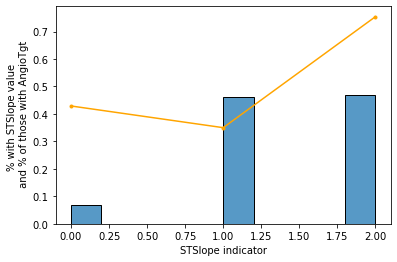

In [60]:
trendOverCategory('STSlope')

STSlope is another pretty fair indicator of AngioTgt, but the 8% of subjects on the left had a higher incidence of AngioTgt than the ones in the middle.  Correlation of 0.35

[(1, 0.08), (2, 0.126), (3, 0.174), (4, 0.559)]


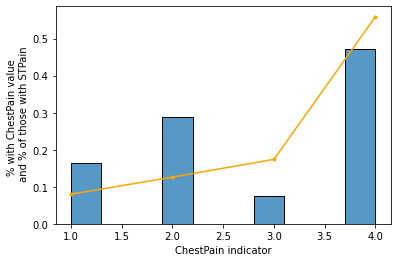

In [61]:
trendOverCategory('ChestPain', 'STPain')

ChestPain is an inverted ordinal, as we saw in Data Wrangling.  4 indicates no pain at rest.  It seems counterintuitive that those with no resting chest pain complain of pain during the stress test the most, but that's what the data say.  

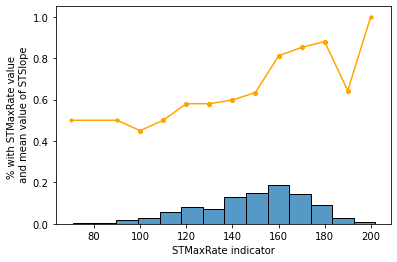

In [62]:
trendOverCategory('STMaxRate', 'STSlope', continuous_feat=True)

[(1, 0.28), (2, 0.793), (3, 1.391), (4, 1.35)]


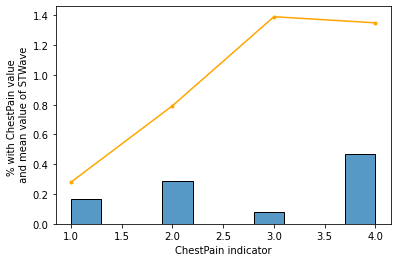

In [66]:
trendOverCategory('ChestPain', 'STWave')

## Negative Correlations to AngioTgt


[(1, 0.82), (2, 0.793), (3, 0.696), (4, 0.273)]


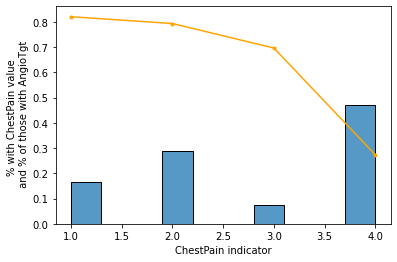

In [67]:
trendOverCategory('ChestPain')

[(0, 0.696), (1, 0.232)]


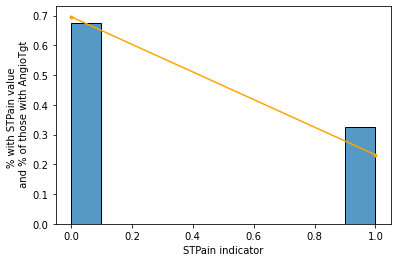

In [68]:
trendOverCategory('STPain')

[(0, 0.748), (1, 0.518), (2, 0.362), (3, 0.12), (4, 0.091), (6, 0.0)]


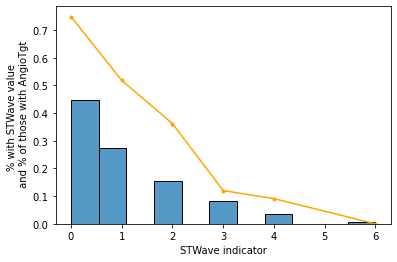

In [69]:
trendOverCategory('STWave')

[(0, 0.743), (1, 0.323), (2, 0.184), (3, 0.15), (4, 0.8)]


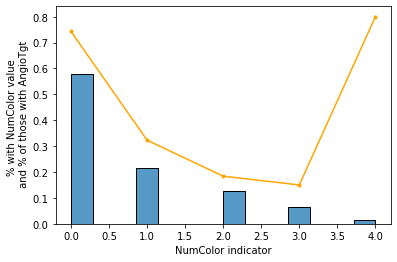

In [70]:
trendOverCategory('NumColor')

[(0, 0.5), (1, 0.333), (2, 0.783), (3, 0.239)]


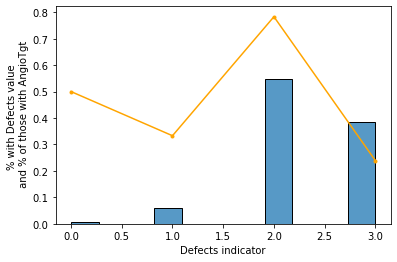

In [71]:
trendOverCategory('Defects')

[(0, 0.75), (1, 0.449)]


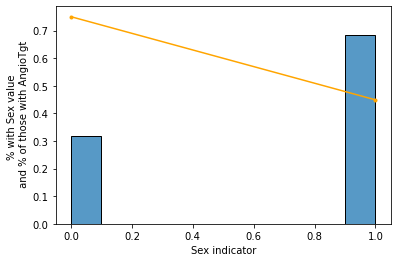

In [72]:
trendOverCategory('Sex')

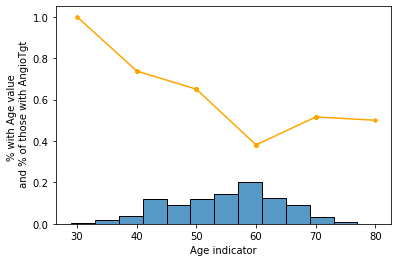

In [74]:
trendOverCategory('Age', continuous_feat=True)

# 3. Candidate Features

Here are the candidate features to use for Feature Engineering:

### Good Continuous Numerical Feature Candidate

* STMaxRate is positively related to AngioTgt.

### Good Categorical Feature Candidates

* ChestPain is negatively related to AngioTgt because 1 is the most severe pain and 4 is no pain.
* STPain is surprisingly negatively related to AngioTgt.  
* STWave is negatively related to AngioTgt.    
* NumColor is negatively related to AngioTgt.
* STSlope is positively related to AngioTgt.   



### Marginal Feature Candidates

* Defects values 2 and 3 contain most of the subjects 2 is high, 3 has low correlation to AngioTgt.
* Sex is surprisingly and weakly negatively related to AngioTgt.
* Age is surprisingly and mildly negatively related to AngioTgt.

### Somewhat Correlated Features might need to choose between them

* STSlope and STWave have a -0.55 correlation coefficient, the largest magnitude of any pair.
* STPain and ChestPain mild positive correlation
* STSlope and STMaxRate mild positive correlation
* STWave and ChestPain mild positive correlation
* STPain and STMaxRate mild negative correlation
* STMaxRate and ChestPain mild negative correlation
* STWave and STMaxRate mild negative correlation

### Poor Continuous Feature Candidates

* SystolicBP is surprisingly and weakly negatively related to AngioTgt.
* Cholesterol is surprisingly not related to AngioTgt, according to this data.

### Poor Categorical Feature Candidates

* RestECG is only weakly positively correlated to AngioTgt.
* Glucose (>120 or Diabetic) is surprisingly not related to AngioTgt, according to this data.

